In [ ]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

ModuleNotFoundError: No module named 'IPython.extensions.deduperreload'

In [2]:
# -*- coding: utf-8 -*-

# -- Python Standard Library imports
from __future__ import annotations
import logging

# -- Python Non-Standard Library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express.colors as pxcol

from py_fatigue import CycleCount, SNCurve
from py_fatigue.cycle_count.rainflow import findtp
from py_fatigue.damage.stress_life import (
    calc_pm, calc_nonlinear_damage_with_dca, calc_theil_sn_damage, _calc_theil_sn_damage
)
from py_fatigue.testing import get_random_data
# from scipy.optimize import fsolve


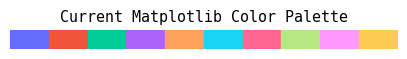

In [ ]:
# # ** Setup

SHOW_MPL_TICKS_AND_LABELS = True
# color palette
# Convert Plotly RGB colors to hex format
def rgb_to_hex(rgb_str: str) -> str:
    """Extract RGB values from the string. Accepts both RGB and hex formats."""
    if rgb_str.startswith('#') and len(rgb_str) == 7 and \
        all(c in '0123456789abcdefABCDEF' for c in rgb_str[1:].upper().strip()):
        return rgb_str
    rgb_values = [int(x) for x in rgb_str.replace(
        'rgb(', ''
    ).replace(')', '').split(',')]
    # Convert to hex
    return '#{:02x}{:02x}{:02x}'.format(*rgb_values)

# Custom function for spines positioning and arrows
def customize_axes(ax: plt.Axes, as_math: bool = False) -> plt.Axes:
    """Customize the axes of a Matplotlib plot by setting the spines positions
    and adding arrows."""
    if not as_math:
        return ax
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_position(("data", 0))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
    return ax

PALETTE = pxcol.qualitative.Plotly
HEX_PALETTE = [rgb_to_hex(color) for color in PALETTE]

# matplotlib tweaking
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=HEX_PALETTE)
plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.rcParams['font.family'] = ['monospace', 'Arial', 'sans-serif',
                               'Times New Roman', 'serif']
plt.rcParams['font.size'] = 9
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = '#AAAAAA'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['axes.spines.right'] = not SHOW_MPL_TICKS_AND_LABELS
plt.rcParams['axes.spines.top'] = not SHOW_MPL_TICKS_AND_LABELS
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.bottom'] = True  # SHOW_MPL_TICKS_AND_LABELS
plt.rcParams['xtick.labelbottom'] = SHOW_MPL_TICKS_AND_LABELS
plt.rcParams['ytick.left'] = True  # SHOW_MPL_TICKS_AND_LABELS
plt.rcParams['ytick.labelleft'] = SHOW_MPL_TICKS_AND_LABELS


# pandas display maximum num of characters in column
# * max nr of rows. Set to as much as you wish
pd.set_option('display.max_rows', 200)
# * max nr of columns. Set to as much as you wish
pd.set_option('display.max_columns', 100)
# * display width. Beyond it a scrollbar is shown
pd.set_option('display.width', 1000)

# Create a figure to display the current color palette
fig, ax = plt.subplots(figsize=(5, 0.25))
for i, color in enumerate(HEX_PALETTE):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, len(HEX_PALETTE))
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('Current Matplotlib Color Palette')
plt.show()


# Implementation of Pavlou Damage Accumulation Paper

DOI: [10.1111/mice.12783](https://doi.org/10.1111/mice.12783)


In [ ]:
# # **Logging

class CustomFormatter(logging.Formatter):
    """Logging Formatter to add colors and count warning / errors"""

    grey = "\033[38m"
    blue = "\033[34m"
    yellow = "\033[33m"
    red = "\033[31m"
    bold = "\033[1m"
    italic = "\033[3m"
    reset = "\033[0m"
    level = "\033[1m%(levelname)-8s → \033[22m"
    message = "%(message)s"

    FORMATS = {
        logging.DEBUG: grey + "🐞 " + level + italic + message + reset,
        logging.INFO: blue + "ℹ️ " + level + italic + message + reset,
        logging.WARNING: yellow + "⚠️ " + level + italic + message + reset,
        logging.ERROR: red + "⛔ " + level + italic + message + reset,
        logging.CRITICAL: red + "🆘 " + level + bold + italic + message + reset
    }

    def format(self, record):
        log_fmt = self.FORMATS.get(record.levelno)
        formatter = logging.Formatter(log_fmt)
        return formatter.format(record)


In [ ]:
# # ** Generate turning point sequence (reversals) from a signal

def generate_reversals(
    stress: list[float] | np.ndarray,
    time_: list[float] | np.ndarray | None = None,
    plot: bool = False,
) -> tuple[list[float], list[float]]:

    # Initial checks
    if isinstance(stress, list):
        stress = np.array(stress)
    # Find the indices of the reversals
    reversal_idx = findtp(stress)

    # Create a mask to filter out non-reversal points
    reversal_mask = np.zeros(len(stress), dtype=bool)
    reversal_mask[reversal_idx] = True
    non_reversal_idx = np.where(~reversal_mask)[0]

    reversals = stress[reversal_mask]         

    if time_ is not None:
        if isinstance(time_, list):
            time_ = np.array(time_)
        filtered_time = time_[reversal_mask].tolist()
    else:
        # Suppose a frequency of 1 Hz
        time_ = np.arange(0, len(stress), 1)
        filtered_time = time_[reversal_mask].tolist()


    if plot:
        # Create figure and gridspec
        fig = plt.figure(figsize=(12, 6))
        gs = plt.GridSpec(2, 1, height_ratios=[.99, .99], hspace=0.5)

        # First subplot - Signal with Non-reversal Points
        ax1 = fig.add_subplot(gs[0])
        ax1.plot(time_, stress, label='Original Signal', alpha=0.5)
        ax1.plot(time_[non_reversal_idx], stress[non_reversal_idx], 
                'x', label='Non-reversal points', markersize=6)
        ax1.set_xlabel('Time, s')
        ax1.set_ylabel('Stress, MPa')
        ax1.set_title('Signal with Non-reversal Points Highlighted')
        ax1.legend(loc='upper right')
        ax1 = customize_axes(ax1)

        # Second subplot - Original vs Filtered Signal
        ax2 = fig.add_subplot(gs[1])
        ax2.plot(time_, stress, c=HEX_PALETTE[0],
                label='Original Signal', alpha=0.5, linewidth=2)
        ax2.plot(filtered_time, reversals, c=HEX_PALETTE[4],
                ls='-', label='Reversals-only Signal', linewidth=0.5)
        ax2.set_xlabel('Time, s')
        ax2.set_ylabel('Stress, MPa')
        ax2.set_title('Original Signal vs Signal without Non-reversal Points')
        ax2.legend(loc='upper right')
        ax2 = customize_axes(ax2)

        plt.show()
    return reversals, filtered_time


In [ ]:
# # ** Pavlou's cycle counting algorithm

def count_cycles(
    stress: list[float] | np.ndarray,
    time_: list[float] | np.ndarray | None = None,
    plot: bool = False,
    logger: logging.Logger | None = None
) -> pd.DataFrame:
    """Count the number of cycles in a stress signal using Pavlou's algorithm.

    # TODO: Add algorithm description

    Parameters
    ----------
    stress : list[float] | np.ndarray
        The stress signal to be analyzed.
    time_ : list[float] | np.ndarray | None, optional
        The time values corresponding to the stress signal, by default None.
    plot : bool, optional
        Whether to plot the stress signal and the identified cycles, by default
        False.
    logger : logging.Logger | None, optional
        The logger object to use for logging, by default None.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the identified cycles.
    """

    reversals, filtered_time = generate_reversals(stress, time_, plot)
    num_points = len(reversals)

    # Initialize arrays with NaN for better handling of missing values
    peaks_before_counting = np.full(num_points, np.nan)
    valleys_before_counting = np.full(num_points, np.nan)
    counted_peaks = np.full(num_points, np.nan)
    counted_valleys = np.full(num_points, np.nan)

    # Identify peaks and valleys
    is_first_peak = reversals[0] > reversals[1]
    if reversals[0] > reversals[1]:
        peaks_before_counting[::2] = reversals[::2]  # Peaks are at even indices
        valleys_before_counting[1::2] = reversals[1::2]  # Valleys are at odd indices
    else:
        valleys_before_counting[::2] = reversals[::2]  # Valleys are at even indices
        peaks_before_counting[1::2] = reversals[1::2]  # Peaks are at odd indices

    # Check if the last value is a peak or a valley
    if (num_points % 2 == 0) == is_first_peak:
        peaks_before_counting[-1] = reversals[-1]  # Last value is a peak
        if logger is not None:
            logger.info("---Last reversal value is a peak---")
    else:
        valleys_before_counting[-1] = reversals[-1]  # Last value is a valley
        if logger is not None:
            logger.info("---Last reversal value is a valley---")

    if len(peaks_before_counting) < 100 and logger is not None:
        logger.debug(f"Peaks before counting: {peaks_before_counting}")
        logger.debug(f"Valleys before counting: {valleys_before_counting}")
    # print(f"Peaks before counting: \n{peaks_before_counting}")
    # print(f"Valleys before counting: \n{valleys_before_counting}")
    counted_peaks = peaks_before_counting.copy()

    # Count valleys using a loop
    for i in range(1, num_points - 1):
        # print(f"Peak at index {i} is {peaks_before_counting[i]}")
        if np.isnan(peaks_before_counting[i]):  # If there's no peak at this index
            # Pair the valley with the closer peak
            # print(f"Valley at index {i} is {valleys_before_counting[i]}")
            left_diff = abs(peaks_before_counting[i - 1] - valleys_before_counting[i])
            right_diff = abs(peaks_before_counting[i + 1] - valleys_before_counting[i])
            if right_diff > left_diff:
                counted_valleys[i - 1] = valleys_before_counting[i]
                counted_valleys[i + 1] = 0
            else:
                counted_valleys[i - 1] = 0
                counted_valleys[i + 1] = valleys_before_counting[i]

    if len(counted_peaks) < 100 and logger is not None:
        logger.debug(f"Counted peaks: {counted_peaks}")
        logger.debug(f"Counted valleys: {counted_valleys}")
    # Pair peaks and valleys into cycles using boolean indexing
    valid_cycles = ~np.isnan(counted_peaks) & ~np.isnan(counted_valleys)
    cycles = np.column_stack((counted_peaks[valid_cycles], counted_valleys[valid_cycles]))

    # Convert to DataFrame
    cycles_df = pd.DataFrame(cycles, columns=['max', 'min'])
    if filtered_time is not None:
        cycles_df['time'] = np.array(filtered_time)[valid_cycles]
    cycles_df["amplitude"] = ((cycles_df["max"] - cycles_df["min"]) / 2).abs()
    cycles_df["mean"] = (cycles_df["max"] + cycles_df["min"]) / 2
    # Reshape the DataFrame for better readability
    cycles_df = cycles_df[['min', 'max', 'mean', 'amplitude', 'time']]
    return cycles_df


In [ ]:
# # ** Generalized Goodman Correction

def general_goodman_correction(
    amp_in: np.ndarray | list[float],
    mean_in: np.ndarray | list[float],
    r_out: float | np.ndarray | list[float],
    ult_s: float,
    correction_exponent: float,
    initial_guess: np.ndarray | None = None,
    plot: bool = False,
    logger: logging.Logger | None = None,
) -> tuple[np.ndarray, np.ndarray, plt.Figure | None]:
    """
    Solves the implicit Goodman correction formula for fatigue analysis using
    the fsolve function from scipy.optimize which is a numerical solver for
    non-linear equations. It uses the Newton-Raphson method to find the roots
    of the implicit equation.

    The formula being solved is:

    .. math::
    
        amp_out =  \left( \frac{1 - \left( \frac{(1 + r_in) \cdot amp_in}
                                                {(1 - r_in) \cdot ult_s}
                                    \right)^n}{amp_in}
                 + amp_out^{n-1} \cdot \left( \frac{(1 + r_out)}{(1 - r_out)
                                                    \cdot ult_s}
                                    \right)^n \right)^{-1}

    where r:sub:`in` = min / max = (mean - amp) / (mean + amp) is the input
    stress ratio, r:sub:`out` is the output stress ratio, amp:sub:`in` is the
    input amplitude, amp:sub:`out` is the output amplitude, ult:sub:`s` is the
    ultimate strength of the material, and n is the correction exponent.

    Parameters
    ----------
    amp_in : np.ndarray | list
        Input amplitude values.
    mean_in : np.ndarray | list
        Input mean stress values.
    r_out : float | np.ndarray
        Output stress ratio values.
    ult_s : float
        Ultimate strength of the material.
    correction_exponent : float
        Mean stress correction exponent (n).

    Returns
    -------
    tuple[np.ndarray, np.ndarray] | tuple[np.ndarray, np.ndarray, plt.Figure]
        Computed amp_out values, corresponding mean_out values, and the figure
        object if plot is set to True.
    """
    # Convert inputs to numpy arrays for element-wise operations
    amp_in = np.asarray(amp_in, dtype=np.float64)
    mean_in = np.asarray(mean_in, dtype=np.float64)
    if np.isscalar(r_out):
        r_out = np.array([r_out], dtype=np.float64)
    r_out = np.asarray(r_out, dtype=np.float64)
    # Check that the input arrays have the same shape
    if amp_in.shape != mean_in.shape:
        raise ValueError("amp_in and mean_in must have the same shape")
    # Check that all values in amp_in are positive
    if np.any(amp_in < 0):
        raise ValueError("You have negative stress amplitude values in amp_in")
    # Check that, if the product of the size of amp_in and r_out is greater
    # than 1,000,000, the user has set plot to False
    if amp_in.size * r_out.size > 10_000 and plot:
        if logger is not None:
            # fmt: off
            logger.warning("\033[1mThe number of points in the input arrays "
                           "is too large for plotting\033[0m")
            logger.info("Setting plot to False to avoid matplotlib errors")
            # fmt: on
        plot = False
    # Compute r_in from amp_in and mean_in
    r_in = (mean_in - amp_in) / (mean_in + amp_in)
    mean_in = amp_in * (1 + r_in) / (1 - r_in)
    # Initial guess for amp_out set to Goodman Correction for r_out = - 1
    if initial_guess is None:
        initial_guess = amp_in / (1 -( mean_in / ult_s) ** correction_exponent)
    # Set initial guess equal to zero wherever r_in > 1
    initial_guess[r_in > 1] = 0


    def implicit_equation(
        amp_out_val: float,
        amp_in_val: float,
        r_in_val: float,
        r_out_val: float,
    ) -> float:
        """Implicit equation to solve for amp_out."""
        if r_in_val == 1:
            # fmt: off
            raise ValueError(f"Input load ratio equals 1 at amp_in={amp_in_val}"
                             ", meaning static load. Revise input data.")
            # fmt: on
        trm1 = (1 + r_in_val) / (1 - r_in_val) * amp_in_val / ult_s
        trm2 = (1 + r_out_val) / (1 - r_out_val) / ult_s

        lhs = amp_out_val
        # fmt: off
        rhs = (1 - trm1**correction_exponent) / amp_in_val + \
              amp_out_val**(correction_exponent - 1) * trm2**correction_exponent
        # fmt: on
        return lhs - rhs**-1

    # Solve for each amp_out using fsolve
    amp_out = []
    mean_out = []
    for r_out_val in r_out:
        # NOTE: Special cases for r_out = -1 and r_out = 0
        # NOTE: These cases are solved analytically to improve performance
        if r_out_val == -1:
            amp_out.append(amp_in / (1 - (mean_in / ult_s) ** correction_exponent))
            mean_out.append(np.zeros_like(amp_in))
            continue
        amp_out_fsolve = []
        for i in range(len(initial_guess)):
            # Solve the implicit equation using fsolve
            # fmt: off
            if mean_in[i] + amp_in[i] > 0:
                sol = fsolve(implicit_equation, x0=initial_guess[i],
                             args=(amp_in[i], r_in[i], r_out_val))
            else:
                sol = (amp_in[i],)
            # Check if fsolve converged or not
            if len(sol) == 0:
                if logger is not None:
                    logger.warning(f"fsolve did not converge for amp_in="
                                   f"{amp_in[i]}, r_in={r_in[i]}, r_out="
                                   f"{r_out_val}")
                amp_out_fsolve.append(np.nan)
            else:
                amp_out_fsolve.append(sol[0] if sol[0] < ult_s else ult_s)
            # fmt: on
        amp_out.append(amp_out_fsolve)
        mean_out.append(calculate_mean_stress(r_out_val, amp_out_fsolve))

    if not plot:
        return np.array(amp_out), np.array(mean_out), None

    amp_out = np.array(amp_out)
    mean_out = np.array(mean_out)
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # First subplot: amp_out vs r_out
    # fmt: off
    for i in range(len(amp_in)):
        ax1.plot(r_out, amp_out[:, i],
                marker='.', markersize=2, linewidth=0.5,
                label=f"$amp_{{in}}={np.round(amp_in[i], 1)}, "
                    f"r_{{in}}={np.round(r_in[i], 2)}$")
    ax1.plot(r_in, amp_in,
            'o', color='yellow', markersize=4, markeredgecolor='black',
            markeredgewidth=0.5, label='Original Data')
    ax1.set_xlabel("$R_{out}$")
    ax1.set_ylabel("$amp_{out}$")
    ax1.set_title("Goodman Correction - Amplitude vs R")
    ax1 = customize_axes(ax1)
    ax1.set_xlim(right=1.25)
    ax1.set_ylim(top=min(max(amp_in) * 1.5, ult_s))
    ax1.grid(True)

    # Second subplot: mean_out vs amp_out
    for i in range(len(amp_in)):
        ax2.plot(mean_out[:, i], amp_out[:, i],
                marker='.', markersize=2, linewidth=0.5,
                label=f"$amp_{{in}}={np.round(amp_in[i], 1)}, "
                    f"r_{{in}}={np.round(r_in[i], 2)}$")
    ax2.plot(calculate_mean_stress(r_in, amp_in), amp_in,
            'o', color='yellow', markersize=4, markeredgecolor='black',
            markeredgewidth=0.5, label='Original Data')

    # Set limits to maximum stress amplitude and ultimate strength
    ax2.set_xlim(right=ult_s * 1.1)
    ax2.set_ylim(top=min(max(amp_in) * 1.5, ult_s))
    # draw lines at constant load ratio for better visualization

    for r in [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75]:
        sample_mean_out = np.linspace(0, ult_s * i, 2)
        ax2.plot(sample_mean_out, (1 - r) / (1 + r) * sample_mean_out, ':',
                 color='#AAAAAA', linewidth=0.75)
    ax2.set_xlabel("$mean_{out}$")
    ax2.set_ylabel("$amp_{out}$")
    ax2.set_title("Goodman Correction - Amplitude vs Mean")
    ax2 = customize_axes(ax2)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.grid(False)

    # Adjust layout and show legend
    plt.tight_layout()
    fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.05),
                loc='upper center', ncol=4)
    plt.show()
    # fmt: on

    return amp_out, mean_out, fig

def calculate_mean_stress(
    load_ratio: float | np.ndarray | list,
    stress_amplitude: float | np.ndarray | list
) -> float | np.ndarray:
    """
    Calculate the mean stress based on the load ratio and stress amplitude.

    The relationship is:

        mean_stress = stress_amplitude * (1 + load_ratio) / 2

    Parameters
    ----------
    load_ratio : float | np.ndarray | list
        Load ratio (minimum stress / maximum stress).
    stress_amplitude : float | np.ndarray | list
        Stress amplitude (half the range of stress variation).

    Returns
    -------
    float | np.ndarray
        Calculated mean stress.
    """
    if isinstance(load_ratio, list):
        load_ratio = np.array(load_ratio)
    if isinstance(stress_amplitude, list):
        stress_amplitude = np.array(stress_amplitude)
    return stress_amplitude * (1 + load_ratio) / (1 - load_ratio)


In [ ]:
# # # ** Pavlou Non-Linear Damage Model

# def pavlou_damage(
#     stress_amplitude: np.ndarray,
#     pm_damage: np.ndarray,
#     ult_s: float,
#     base_exponent: float = -0.75,
#     damage_bands: list[float] | np.ndarray = [0, 0.025, 0.05, 0.1, 0.2, 0.3,
#                                               0.4, 0.5, 0.6, 0.7, 0.8, 1],
#     limit_damage: float = 1,
#     plot: bool = False,
#     logger: logging.Logger | None = None,
# ) -> tuple[np.ndarray, np.ndarray] | tuple[np.ndarray, np.ndarray, plt.Figure]:
#     """
#     Calculate the Pavlou damage for each cycle based on the stress amplitude
#     and the Palmgren-Miner damage.

#     The Pavlou damage is calculated using the following concept:

#     The total damage is the sum of the damage within each damage band :math:`j`:

#     .. math::

#         D = \sum_{j=1}^{m} \Delta D_j

#     Within a damage band :math:`j`, the damage increment :math:`\Delta D_j` is

#     .. math::

#         \Delta D_j = \sum_{i=1}^{n} D_{ij} = \sum_{i=1}^{n} w_{ij} \cdot \frac{n_i}{N_i}

#     where :math:`n_i` is the number of cycles at stress amplitude :math:`\sigma_i`
#     and :math:`N_i` is number of cycles to failure at :math:`\sigma_i` given by
#     the S-N curve. Therefore:

#     .. math::

#         D = \sum_{j=1}^{m} \sum_{i=1}^{n} w_{ij} \cdot \frac{n_i}{N_i}

#     Each weight :math:`w_{ij}` is calculated as:

#     .. math::

#         w_{ij} = \frac{DB_{j} - DB_{j-1}}{DB_{j}^{1/q(\sigma_i)} - DB_{j-1}^{1/q(\sigma_i)}}

#     and:

#     .. math::

#         q(\sigma_i) = \left( \frac{\sigma_i}{\sigma_{ult}} \right)^{b}

#     where :math:`\sigma_i` is the stress amplitude, :math:`\sigma_{ult}` is the
#     ultimate strength of the material, :math:`b` is the base exponent (defaults
#     to -0.75), and :math:`DB_{j}` is the upper limit of the damage band :math:`j`.

#     Parameters
#     ----------
#     stress : np.ndarray | list
#         Stress amplitude values.
#     pm_damage : np.ndarray | list
#         Palmgren-Miner damage values.
#     ult_s : float
#         Ultimate strength of the material.
#     base_exponent : float, optional
#         Exponent for the Pavlou damage calculation, by default -0.75
#     damage_bands : list[float], optional
#         Damage bands for the Pavlou damage calculation, by default
#         [0, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
#     limit_damage : float, optional
#         Limit damage value, by default 1

#     Returns
#     -------
#     tuple[np.ndarray, np.ndarray, plt.Figure | None]
#         Pavlou damage values, cumulative Pavlou damage values, and the figure
#         object if plot is set to True.
#     """
#     stress_amplitude = np.asarray(stress_amplitude, dtype=np.float64)
#     pm_damage = np.asarray(pm_damage, dtype=np.float64)
#     damage_bands = np.asarray(damage_bands, dtype=np.float64)
#     # Check that the size of the damage bands is at least two:
#     if len(damage_bands) < 2:
#         raise ValueError("The damage bands must have at least two values")

#     pavlou_exp =  (stress_amplitude / ult_s) ** base_exponent

#     # Initialize an array to store the damage values
#     pavlou_dmg = pm_damage.copy()
#     cumsum_pavlou_dmg = np.zeros_like(pavlou_dmg)
#     for i in range(0, len(stress_amplitude)):
#         prev_dmg_band = cur_dmg_band if i >= 1 else 0
#         # Current damage value
#         # fmt: off
#         if i >= 1 and cumsum_pavlou_dmg[i] > limit_damage \
#                   and cumsum_pavlou_dmg[i - 1] < limit_damage \
#                   and logger is not None:
#             logger.warning(f"Damage value exceeds 1 at index {i}")
#         # Identify in which band the current damage falls
#         cur_dmg_band = np.digitize(cumsum_pavlou_dmg[i-1], damage_bands,
#                                    right=False) if i >= 1 else 0
#         if cur_dmg_band >= len(damage_bands) - 1:
#             cur_dmg_band = len(damage_bands) - 1

#         if cur_dmg_band != prev_dmg_band and len(damage_bands) < 20 \
#                                          and logger is not None:
#             if cur_dmg_band == 1:
#                 logger.info(f"Damage band change")     
#             logger.info(f"‣ at cycle {i}:\n"
#                         f"                • from {prev_dmg_band} to "
#                         f"{cur_dmg_band} ({damage_bands[cur_dmg_band - 1]}"
#                         f" < D ≤ {damage_bands[cur_dmg_band]})\n"
#                         f"                • current damage value: "
#                         f"{cumsum_pavlou_dmg[i-1]}\033[0m")
        
#         # If the current damage exceeds the limit, warn:
#         if cumsum_pavlou_dmg[i-2] <= limit_damage < cumsum_pavlou_dmg[i-1] \
#         and logger is not None:
#             logger.critical(f"Damage value exceeds 1 at index {i}: "
#                             f"{cumsum_pavlou_dmg[i-1]}")
#         # Damage weight for the current cycle
#         w_ij: float = (damage_bands[cur_dmg_band] - 
#                        damage_bands[cur_dmg_band - 1]) / \
#                       ((damage_bands[cur_dmg_band] ** (1 / pavlou_exp[i])) -
#                        (damage_bands[cur_dmg_band - 1] ** (1 / pavlou_exp[i])))
#         # fmt: on

#         # Update the damage value for the current cycle
#         pavlou_dmg[i] = w_ij * pm_damage[i] if i >= 1 else pm_damage[0]
#         cumsum_pavlou_dmg[i] = pavlou_dmg[i] + cumsum_pavlou_dmg[i - 1] \
#                                if i >= 1 else pavlou_dmg[0]

#     if not plot:
#         return pavlou_dmg, cumsum_pavlou_dmg, None

#     fig, ax = plt.subplots(figsize=(12, 4))
#     cumsum_pm_dmg = np.cumsum(pm_damage)
#     # fmt: off
#     ax.plot(cumsum_pavlou_dmg[cumsum_pavlou_dmg < 1], label="Pavlou Damage",
#             lw=1)
#     ax.plot(cumsum_pm_dmg[cumsum_pm_dmg < 1], label="Palmgren-Miner Damage",
#             lw=1)
#     ax.set_xlabel("Cycles")
#     ax.set_ylabel("Cumulative Damage")
#     ax.set_title("Pavlou VS Palmgren-Miner Damage Accumulation")
#     ax.legend(loc="lower right", ncol=4)
#     ax = customize_axes(ax)
#     ax.set_ylim(top=min(1, max(cumsum_pavlou_dmg)))
#     # Add a vertical line where the damage exceeds 1
#     if np.any(cumsum_pavlou_dmg > 1):
#         ax.axvline(np.argmax(cumsum_pavlou_dmg > 1), color='firebrick',
#                     linestyle='--', label='Pavlou damage Exceeds 1')
#     if np.any(cumsum_pm_dmg > 1):
#         ax.axvline(np.argmax(cumsum_pm_dmg > 1), color='crimson',
#                     linestyle='--', label='Palmgren-Mineramage Exceeds 1')
#     # fmt: on
#     plt.show()
#     return pavlou_dmg, cumsum_pavlou_dmg, fig


## Usage example

The following cells show how to use the functions implemented in this notebook.

Said functions, will become part of the new version of `py-fatigue` in the
future.


In [ ]:
# # ** Logger setup

# Define a custom logger only if no other logger is defined
try:
    logger  # type: ignore
except NameError:
    logger = logging.getLogger("Notebook")
    logger.setLevel(logging.DEBUG)

    # create console handler with a higher log level
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)

    ch.setFormatter(CustomFormatter())

    logger.addHandler(ch)

logger.debug("Example debug message")
logger.info("Example info message")
logger.warning("Example warning message")
logger.error("Example error message")
logger.critical("Example critical message")


In [ ]:
# To create any random signal, it is very convenient to use the following function.
# It comes from https://owi-lab.github.io/py_fatigue/api/testing.html#py_fatigue.testing.get_random_data

duration = 500001
min_ = 0
range_ = 550
# kwargs = {"random_type": "weibull", "a": 1.5}
kwargs = {"random_type": "normal", "loc": 0, "scale": 1}
# kwargs = {"random_type": "uniform"}

time_ = np.linspace(0, duration + 1, duration + 1)
stress = get_random_data(t=time_, min_=min_, range_=range_, **kwargs)
    
fig, ax = plt.subplots()
ax.plot(time_, stress, lw=0.5)
ax.set_xlabel("Time, s")
ax.set_ylabel("Stress, MPa")
ax.set_title(f"Random Stress Signal with {kwargs['random_type'].capitalize()} "
             "Distribution")
ax = customize_axes(ax)
plt.show()


In [ ]:
# # ** Cycle-counting according to Pavlou's paper

cyclecount_df = count_cycles(
    stress, time_=time_, plot=True, logger=logger
)
display(cyclecount_df.head(5))


In [ ]:
# # ** Goodman Correction

amp_in = cyclecount_df["amplitude"].values
mean_in = cyclecount_df["mean"].values
# r_out_values = np.array([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, .99])
r_out_values = np.array([-1.0])
ult_s = 900.0
correction_exponent = 1

(solved_amp_out, mean_out, _
) = general_goodman_correction(amp_in, mean_in, r_out_values, ult_s,
                               correction_exponent, plot=True, logger=logger)

# Identify the goodman_amplitude array as the one corresponding to the selected
# value of r_goodman
r_goodman = -1
cyclecount_df["amplitude_gc"] = solved_amp_out[
    r_out_values == r_goodman
].flatten()
cyclecount_df["mean_gc"] = mean_out[r_out_values == r_goodman].flatten()
display(cyclecount_df.head())


In [ ]:
# # ** SN Curve

log_a = 11.687
b = 3

sn_curve = SNCurve(slope=b, intercept=log_a, color=HEX_PALETTE[2],
                   environment='seawater with free corrosion',
                   norm='DNV-RP-C203', curve='D')
display(sn_curve)

# # ** Palmgren-Miner Rule

cyclecount_df["dmg_pm"] = calc_pm(2 * cyclecount_df["amplitude_gc"],
                                 np.ones(len(cyclecount_df)),
                                 sn_curve)
cyclecount_df["cumsum_dmg_pm"] = cyclecount_df["dmg_pm"].cumsum()
display(cyclecount_df.head())


In [ ]:
# # ** Pavlou's Damage Model

cyclecount_df["dmg_pavlou"], cyclecount_df["cumsum_dmg_pavlou"], _ = pavlou_damage(
    cyclecount_df["amplitude_gc"], cyclecount_df["dmg_pm"], ult_s, plot=True,
    # damage_bands=[0, 0.5, 1],
    # damage_bands: list[float] | np.ndarray = np.linspace(0, 1, 10001),
    base_exponent=-0.75,
    logger=logger
)

display(cyclecount_df.tail(10))


In [ ]:
pav__, pav_cumsum__, fig, ax = calc_nonlinear_damage_with_dca(
    "pavlou",
    cyclecount_df["amplitude_gc"] * 2,
    np.ones(len(cyclecount_df)),
    sn_curve,
    ultimate_stress=900,
    base_exponent=-0.75,
    plot=True
)


In [ ]:

theil__, theil_cumsum__, fig, ax = calc_nonlinear_damage_with_dca(
    "theil",
    cyclecount_df["amplitude_gc"] * 2,
    np.ones(len(cyclecount_df)),
    sn_curve,
    plot=True
)


In [ ]:
# Theil model 
history = _calc_theil_cycles_to_failure(
    (cyclecount_df["amplitude_gc"] * 2).to_numpy(),
    np.ones(len(cyclecount_df)),
    cycles_to_failure=sn_curve.get_cycles((cyclecount_df["amplitude_gc"] * 2).to_numpy()),
)
print(history[0:10])

In [ ]:
# Theil model 
history = calc_theil_cycles_to_failure(
    (cyclecount_df["amplitude_gc"] * 2).to_numpy(),
    np.ones(len(cyclecount_df)),
    sn_curve=sn_curve,
)


In [ ]:
cycles = np.logspace(2, np.log10(1E5) + 1, 100)
# fmt: off
fig, ax = plt.subplots(1,1)
ax.plot(cycles, sn_curve.get_stress(cycles), "k", lw=1,
        label=sn_curve.name)
# fmt: on
for n_seg, f_seg, label in history[:9000]:
    ax.plot(n_seg, f_seg, label=label, marker=".")
ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_xlabel("Cycles")
ax.set_ylabel("Stress Range, MPa")
ax.set_xlim(left=1E2)
ax.set_ylim(top=500)
plt.show()

## Py-Fatigue example

In [ ]:
# # ** Using the classic rainflow counting algorithm

cc = CycleCount.from_timeseries(stress, time_, name="Random Cycle Count")
display(cc)

pyfatigue_df = pd.DataFrame(np.array([cc.count_cycle, cc.min_stress,
                                      cc.max_stress, cc.mean_stress,
                                      cc.stress_amplitude]).T,
                            columns=['cycles', 'min', 'max', 'mean',
                                     'amplitude'])

display(pyfatigue_df.tail())

print(f"Size of Rainflow cycle count: {len(pyfatigue_df)}")


In [ ]:
# # ** Goodman Correction

amp_in = pyfatigue_df["amplitude"].values
mean_in = pyfatigue_df["mean"].values
# r_out_values = np.array([-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, .99])
r_out_values = np.array([-1.0])
ult_s = 900.0
correction_exponent = 1

solved_amp_out, mean_out, _ = general_goodman_correction(
    amp_in, mean_in, r_out_values, ult_s, correction_exponent, plot=True
)

# Identify the goodman_amplitude array as the one corresponding to the selected
# value of r_goodman
r_goodman = -1
pyfatigue_df["amplitude_gc"] = solved_amp_out[
    r_out_values == r_goodman
].flatten()
pyfatigue_df["mean_gc"] = mean_out[r_out_values == r_goodman].flatten()
display(pyfatigue_df.tail())


In [ ]:
# Scatter plot of pyfatigue df amplitudes gc and cyclecount df amplitudes gc
# to compare the two. Sort the valuse as descending to make the comparison easier

amp_col = "amplitude_gc"
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(cyclecount_df[amp_col].sort_values(ascending=False).values,
        label="Pavlou", linestyle="-", linewidth=1)
# In py-fatigue df, plot also the cycle-counts, sorted as the amplitude values
sorted_indices = pyfatigue_df[amp_col].sort_values(ascending=False).index
ax.plot(pyfatigue_df["cycles"].iloc[sorted_indices].cumsum().values,
        pyfatigue_df[amp_col].iloc[sorted_indices].values,
        label="Rainflow", linestyle=":", linewidth=1)
ax.legend()
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Amplitude, MPa')
ax.set_title('Amplitude - Rainflow vs Pavlou')
plt.show()

# # ** Palmgren-Miner Rule

pyfatigue_df["dmg_pm"] = calc_pm(2 * pyfatigue_df[amp_col],
                                 pyfatigue_df["cycles"],
                                 sn_curve)

pyfatigue_df["cumsum_dmg_pm"] = pyfatigue_df["dmg_pm"].cumsum()
display(pyfatigue_df.tail())


In [ ]:
pyfatigue_df["dmg_pavlou"], pyfatigue_df["cumsum_dmg_pavlou"], _ = pavlou_damage(
    pyfatigue_df[amp_col], pyfatigue_df["dmg_pm"], ult_s, plot=True
)

display(pyfatigue_df.tail(10))
